## Bank account fraud classification

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np

## Data preprocessing and visualization

In [9]:
df = pd.read_csv("Base.csv")
pd.set_option('display.max_columns', 32) # Want to be able to see all the columns

#### There are non-quantitative variables that need to be processed

In [3]:
# Display the first 5 rows to get a look at the columns
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


#### Following plot shows that the number of fraud data points is about 1% of the entire dataset, thus, accuracy is not a good indicator of model performance

<AxesSubplot: >

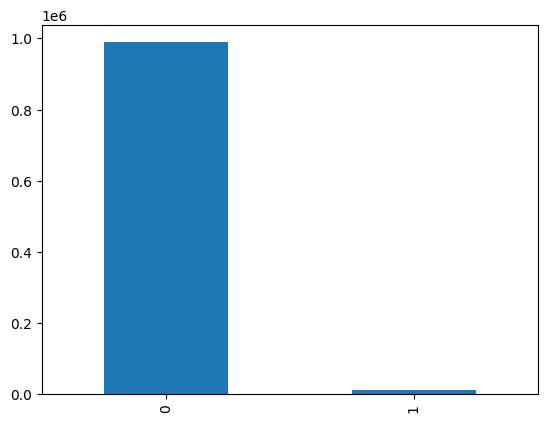

In [4]:
df['fraud_bool'].value_counts().plot(kind='bar') # This is an extremely imbalanced dataset

In [5]:
df.info() # Get information about the variables and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [6]:
df.nunique() # Check how many unique values each of these columns have

fraud_bool                               2
income                                   9
name_email_similarity               998861
prev_address_months_count              374
current_address_months_count           423
customer_age                             9
days_since_request                  989330
intended_balcon_amount              994971
payment_type                             5
zip_count_4w                          6306
velocity_6h                         998687
velocity_24h                        998940
velocity_4w                         998318
bank_branch_count_8w                  2326
date_of_birth_distinct_emails_4w        40
employment_status                        7
credit_risk_score                      551
email_is_free                            2
housing_status                           7
phone_home_valid                         2
phone_mobile_valid                       2
bank_months_count                       33
has_other_cards                          2
proposed_cr

In [10]:
df.describe(include=["object", "bool"]) # Get basic statistical information about the columns that aren't quantitative

,payment_type,employment_status,housing_status,source,device_os
count,1000000,1000000,1000000,1000000,1000000
unique,5,7,7,2,5
top,AB,CA,BC,INTERNET,other
freq,370554,730252,372143,992952,342728


In [12]:
nan_map = df.isna().sum() # Check for NaN values, there shouldn't be any since this is a synthetic dataset but want to make sure
nan_map

fraud_bool                          0
income                              0
name_email_similarity               0
prev_address_months_count           0
current_address_months_count        0
customer_age                        0
days_since_request                  0
intended_balcon_amount              0
payment_type                        0
zip_count_4w                        0
velocity_6h                         0
velocity_24h                        0
velocity_4w                         0
bank_branch_count_8w                0
date_of_birth_distinct_emails_4w    0
employment_status                   0
credit_risk_score                   0
email_is_free                       0
housing_status                      0
phone_home_valid                    0
phone_mobile_valid                  0
bank_months_count                   0
has_other_cards                     0
proposed_credit_limit               0
foreign_request                     0
source                              0
session_leng

### Note: Don't attempt to remove outliers as the entire point of a dataset like this is likely to explore the defining features of outliers

## One hot encode categorical features

Create new columns for each categorical feature, using a 1 to represent it's presence in a row and 0 to represent the fact that it's not there